In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing
from skorch import NeuralNet
from skorch.callbacks import Callback
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loader_to_numpy(loader):
    features, targets = [], []
    for feat, targ in loader:
        features.append(feat.numpy())
        targets.append(targ.numpy())
    return np.concatenate(features), np.concatenate(targets)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat = 499500, input_dim_target = 1, hidden_dim_feat = 1000, output_dim = 2, dropout_rate = 0):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_feat),
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_target),
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [5]:
class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [6]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, test_site = None, regions = None, threshold_mat = False, threshold_percent = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)      
        participant_data = pd.read_csv(path_target)
        targets = np.expand_dims(participant_data[target_name].values, axis = 1)
        

        # Split the dataset into training and test sets
        if test_site is None:
            train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        else:
            test_indices = participant_data.index[participant_data['dataset'] == test_site].values
            train_indices = np.delete(np.arange(len(features)), test_indices)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        if threshold_mat:
            thresholded_feat = []
            for matrix in features:
                threshold = np.percentile(matrix, threshold_percent)
                matrix[matrix < threshold] = 0
                thresholded_feat.append(matrix)
            threshold_feat = np.stack(thresholded_feat)
            features = threshold_feat
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if (train and transform is not None):
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets

In [35]:
class CustomNet(NeuralNet):
    def __init__(self, module, estimator = None, criterion_pft=None, criterion_ptt=None, n_views = None, **kwargs):
        super(CustomNet, self).__init__(module, **kwargs)
        self.criterion_pft_cls = criterion_pft
        self.criterion_ptt_cls = criterion_ptt
        self.n_views = n_views
        self.estimator = estimator
        
    def fit(self, X_train, y_train, **fit_params):
        self.X_train_ = X_train
        self.y_train_ = y_train
        super().fit(X, y, **fit_params)
        print("Model fitted")
    
    def score(self, X, y):
        features, targets = X.to(self.device), y.to(self.device)
        out_feat, _ = self.module_(features, targets)
        self.estimator = self.estimator.fit(out_feat.cpu().numpy())
        y_pred = self.estimator.predict(out_feat.cpu().numpy())
        r2 = self.estimator.r2(out_feat.cpu().numpy())
        
    def get_params(self, deep=True):
        params = super(CustomNet, self).get_params(deep=deep)
        params.update({
            'criterion_pft_cls': self.criterion_pft_cls,
            'criterion_ptt_cls': self.criterion_ptt_cls,
            'n_views': self.n_views,
            'estimator': self.estimator,
        })
        return params

    def set_params(self, **parameters):
        super(CustomNet, self).set_params(**{k: v for k, v in parameters.items() if k not in ['criterion_pft', 'criterion_ptt', 'n_views', 'estimator']})
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def initialize_criterion(self):
        super().initialize_criterion()  # Initialize default criterion first
        # Setup custom criterion with parameters from get_params_for
        if self.criterion_pft_cls is not None:
            self.criterion_pft_ = self.criterion_pft_cls(**self.get_params_for('criterion_pft'))
        if self.criterion_ptt_cls is not None:
            self.criterion_ptt_ = self.criterion_ptt_cls(**self.get_params_for('criterion_ptt'))
        return self
    
    def train_step_single(self, batch, **fit_params):
        self.module_.train()
        features, targets = batch
        features, targets = features.to(self.device), targets.to(self.device)
        self.optimizer_.zero_grad()
        mlp_out = self.module_(features, targets)  # Pass both Xi and yi to forward
        loss = self.get_loss(mlp_out, targets, training=True)
        loss.backward()
        self.optimizer_.step()
        return {'loss': loss}
    
    def validation_step(self, batch, **fit_params):
        self.module_.eval()  # Set the module in evaluation mode
        features = self.X_test_
        targets = self.y_test_
        with torch.no_grad():
            features, targets = features.to(self.device), targets.to(self.device)
            out_feat, out_target = self.module_(features, targets)
        
        loss = self.get_loss((out_feat, out_target), targets, training=False)
        
        if hasattr(self, 'train_proj_'):
            self.estimator = self.estimator.fit(self.train_proj_.cpu().numpy())
            y_pred = self.estimator.predict(out_feat.cpu().numpy())
            r2 = self.estimator.r2(out_feat.cpu().numpy())
        else:
            y_pred = None
            r2 = None
        return {'loss': loss, 'y_pred': y_pred, 'r2':r2}

    def get_loss(self, mlp_out, targets, training=False):
        n_views = self.n_views
        out_feat, out_target = mlp_out
        bsz = out_feat.shape[0]
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1)
        
        loss = self.criterion_pft_(out_feat, targets)
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1)
        
        loss += self.criterion_ptt_(out_target, targets)
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2))
        return loss
    

In [8]:
class ProjCallback(Callback):
    def on_train_end(self, net, **kwargs):
        X_train = getattr(net, 'X_train_', None)
        y_train = getattr(net, 'y_train_', None)
        net.module_.eval()
        with torch.no_grad():
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
            features, _ = net.module_(X_train_tensor, y_train_tensor)
            net.train_proj_ = features

class InitializeCallback(Callback):
    def on_train_begin(self, net, X=None, y=None, **kwargs):
        if not hasattr(net, 'estimator'):
            net.estimator = AgeEstimator()
        if not hasattr(net, 'criterion_pft_'):
            net.criterion_pft_ = net.criterion_pft(**net.get_params_for('criterion_pft'))
        if not hasattr(net, 'criterion_ptt_'):
            net.criterion_ptt_ = net.criterion_ptt(**net.get_params_for('criterion_ptt'))

In [9]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [10]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str='expw', temperature: float=0.03, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=cauchy, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [11]:
from torch.utils.data import ConcatDataset

train_dataset = MatData("matrices.npy", "participants.csv", "age", train=True, train_size = 100, test_size = 50)
test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, train_size = 100, test_size = 50)
dataset = ConcatDataset([train_dataset, test_dataset])

dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle = False)
X, y = loader_to_numpy(dataloader)
X = X.squeeze(1)

X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]


In [12]:
test_dataset = Dataset(X_test, y_test)

In [37]:
model = CustomNet(
    module=MLP,
    optimizer=optim.Adam,
    lr = 0.01,
    estimator = AgeEstimator(),
    module__input_dim_feat = 499500,
    module__hidden_dim_feat = 1000,
    module__input_dim_target = 1,
    module__output_dim = 2,
    train_split=predefined_split(test_dataset),
    n_views = 1,
    callbacks=[ProjCallback()],
    criterion_pft=KernelizedSupCon,
    criterion_ptt=KernelizedSupCon,
    criterion=torch.nn.MSELoss(),  # Default criterion, actual loss handled in get_loss
    batch_size=20,
    max_epochs=10,
    device='cuda',
)

In [15]:
model.fit(X_train, y_train, X_test, y_test)

TypeError: validation_step() takes 1 positional argument but 2 were given

In [45]:
import numbers
import time
import warnings
from collections import Counter
from contextlib import suppress
from functools import partial
from numbers import Real
from traceback import format_exc

import numpy as np
import scipy.sparse as sp
from joblib import logger

from sklearn.base import clone, is_classifier
from sklearn.exceptions import FitFailedWarning
from sklearn.metrics import check_scoring, get_scorer_names
from sklearn.metrics._scorer import _check_multimetric_scoring, _MultimetricScorer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import _safe_indexing, check_random_state, indexable
from sklearn.utils._param_validation import (
    HasMethods,
    Integral,
    Interval,
    StrOptions,
    validate_params,
)
from sklearn.utils.metaestimators import _safe_split
from sklearn.utils.parallel import Parallel, delayed
from sklearn.utils.validation import _check_fit_params, _num_samples
from sklearn.model_selection._split import check_cv

def create_model():
    # Initialize a new instance of CustomNet
    # Ensure to set up the model with all necessary initializations
    return CustomNet(
        module=MLP,
        optimizer=optim.Adam,
        lr = 0.01,
        estimator = AgeEstimator(),
        module__input_dim_feat = 499500,
        module__hidden_dim_feat = 1000,
        module__input_dim_target = 1,
        module__output_dim = 2,
        train_split=predefined_split(test_dataset),
        n_views = 1,
        callbacks=[ProjCallback()],
        criterion_pft=KernelizedSupCon,
        criterion_ptt=KernelizedSupCon,
        criterion=torch.nn.MSELoss(),  # Default criterion, actual loss handled in get_loss
        batch_size=20,
        max_epochs=10,
        device='cuda')

def learning_curve(
    estimator,
    X,
    y,
    *,
    groups=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=None,
    pre_dispatch="all",
    verbose=0,
    shuffle=False,
    random_state=None,
    error_score=np.nan,
    return_times=False,
    fit_params=None,
    clone_func=clone
):
    """Learning curve.

    Determines cross-validated training and test scores for different training
    set sizes.

    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.

    Read more in the :ref:`User Guide <learning_curve>`.

    Parameters
    ----------
    estimator : object type that implements the "fit" method
        An object of that type which is cloned for each validation. It must
        also implement "predict" unless `scoring` is a callable that doesn't
        rely on "predict" to compute a score.

    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training vector, where `n_samples` is the number of samples and
        `n_features` is the number of features.

    y : array-like of shape (n_samples,) or (n_samples, n_outputs) or None
        Target relative to X for classification or regression;
        None for unsupervised learning.

    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`
        instance (e.g., :class:`GroupKFold`).

    train_sizes : array-like of shape (n_ticks,), \
            default=np.linspace(0.1, 1.0, 5)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - int, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For int/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass, :class:`StratifiedKFold` is used. In all
        other cases, :class:`KFold` is used. These splitters are instantiated
        with `shuffle=False` so the splits will be the same across calls.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.

        .. versionchanged:: 0.22
            ``cv`` default value if None changed from 3-fold to 5-fold.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    exploit_incremental_learning : bool, default=False
        If the estimator supports incremental learning, this will be
        used to speed up fitting for different training set sizes.

    n_jobs : int, default=None
        Number of jobs to run in parallel. Training the estimator and computing
        the score are parallelized over the different training and test sets.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    pre_dispatch : int or str, default='all'
        Number of predispatched jobs for parallel execution (default is
        all). The option can reduce the allocated memory. The str can
        be an expression like '2*n_jobs'.

    verbose : int, default=0
        Controls the verbosity: the higher, the more messages.

    shuffle : bool, default=False
        Whether to shuffle training data before taking prefixes of it
        based on``train_sizes``.

    random_state : int, RandomState instance or None, default=None
        Used when ``shuffle`` is True. Pass an int for reproducible
        output across multiple function calls.
        See :term:`Glossary <random_state>`.

    error_score : 'raise' or numeric, default=np.nan
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If a numeric value is given, FitFailedWarning is raised.

        .. versionadded:: 0.20

    return_times : bool, default=False
        Whether to return the fit and score times.

    fit_params : dict, default=None
        Parameters to pass to the fit method of the estimator.

        .. versionadded:: 0.24

    Returns
    -------
    train_sizes_abs : array of shape (n_unique_ticks,)
        Numbers of training examples that has been used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.

    train_scores : array of shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array of shape (n_ticks, n_cv_folds)
        Scores on test set.

    fit_times : array of shape (n_ticks, n_cv_folds)
        Times spent for fitting in seconds. Only present if ``return_times``
        is True.

    score_times : array of shape (n_ticks, n_cv_folds)
        Times spent for scoring in seconds. Only present if ``return_times``
        is True.

    Examples
    --------
    >>> from sklearn.datasets import make_classification
    >>> from sklearn.tree import DecisionTreeClassifier
    >>> from sklearn.model_selection import learning_curve
    >>> X, y = make_classification(n_samples=100, n_features=10, random_state=42)
    >>> tree = DecisionTreeClassifier(max_depth=4, random_state=42)
    >>> train_size_abs, train_scores, test_scores = learning_curve(
    ...     tree, X, y, train_sizes=[0.3, 0.6, 0.9]
    ... )
    >>> for train_size, cv_train_scores, cv_test_scores in zip(
    ...     train_size_abs, train_scores, test_scores
    ... ):
    ...     print(f"{train_size} samples were used to train the model")
    ...     print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    ...     print(f"The average test accuracy is {cv_test_scores.mean():.2f}")
    24 samples were used to train the model
    The average train accuracy is 1.00
    The average test accuracy is 0.85
    48 samples were used to train the model
    The average train accuracy is 1.00
    The average test accuracy is 0.90
    72 samples were used to train the model
    The average train accuracy is 1.00
    The average test accuracy is 0.93
    """
    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError(
            "An estimator must support the partial_fit interface "
            "to exploit incremental learning"
        )
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)
    print(scorer)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes, n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch, verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(
            delayed(_incremental_fit_estimator)(
                create_model(),
                X,
                y,
                classes,
                train,
                test,
                train_sizes_abs,
                scorer,
                verbose,
                return_times,
                error_score=error_score,
                fit_params=fit_params,
            )
            for train, test in cv_iter
        )
        out = np.asarray(out).transpose((2, 1, 0))
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train_test_proportions.append((train[:n_train_samples], test))

        results = parallel(
            delayed(_fit_and_score)(
                create_model(),
                X,
                y,
                scorer,
                train,
                test,
                verbose,
                parameters=None,
                fit_params=fit_params,
                return_train_score=True,
                error_score=error_score,
                return_times=return_times,
            )
            for train, test in train_test_proportions
        )
        results = _aggregate_score_dicts(results)
        train_scores = results["train_scores"].reshape(-1, n_unique_ticks).T
        test_scores = results["test_scores"].reshape(-1, n_unique_ticks).T
        out = [train_scores, test_scores]

        if return_times:
            fit_times = results["fit_time"].reshape(-1, n_unique_ticks).T
            score_times = results["score_time"].reshape(-1, n_unique_ticks).T
            out.extend([fit_times, score_times])

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret

def _translate_train_sizes(train_sizes, n_max_training_samples):
    """Determine absolute sizes of training subsets and validate 'train_sizes'.

    Examples:
        _translate_train_sizes([0.5, 1.0], 10) -> [5, 10]
        _translate_train_sizes([5, 10], 10) -> [5, 10]

    Parameters
    ----------
    train_sizes : array-like of shape (n_ticks,)
        Numbers of training examples that will be used to generate the
        learning curve. If the dtype is float, it is regarded as a
        fraction of 'n_max_training_samples', i.e. it has to be within (0, 1].

    n_max_training_samples : int
        Maximum number of training samples (upper bound of 'train_sizes').

    Returns
    -------
    train_sizes_abs : array of shape (n_unique_ticks,)
        Numbers of training examples that will be used to generate the
        learning curve. Note that the number of ticks might be less
        than n_ticks because duplicate entries will be removed.
    """
    train_sizes_abs = np.asarray(train_sizes)
    n_ticks = train_sizes_abs.shape[0]
    n_min_required_samples = np.min(train_sizes_abs)
    n_max_required_samples = np.max(train_sizes_abs)
    if np.issubdtype(train_sizes_abs.dtype, np.floating):
        if n_min_required_samples <= 0.0 or n_max_required_samples > 1.0:
            raise ValueError(
                "train_sizes has been interpreted as fractions "
                "of the maximum number of training samples and "
                "must be within (0, 1], but is within [%f, %f]."
                % (n_min_required_samples, n_max_required_samples)
            )
        train_sizes_abs = (train_sizes_abs * n_max_training_samples).astype(
            dtype=int, copy=False
        )
        train_sizes_abs = np.clip(train_sizes_abs, 1, n_max_training_samples)
    else:
        if (
            n_min_required_samples <= 0
            or n_max_required_samples > n_max_training_samples
        ):
            raise ValueError(
                "train_sizes has been interpreted as absolute "
                "numbers of training samples and must be within "
                "(0, %d], but is within [%d, %d]."
                % (
                    n_max_training_samples,
                    n_min_required_samples,
                    n_max_required_samples,
                )
            )

    train_sizes_abs = np.unique(train_sizes_abs)
    if n_ticks > train_sizes_abs.shape[0]:
        warnings.warn(
            "Removed duplicate entries from 'train_sizes'. Number "
            "of ticks will be less than the size of "
            "'train_sizes': %d instead of %d." % (train_sizes_abs.shape[0], n_ticks),
            RuntimeWarning,
        )

    return train_sizes_abs

def _fit_and_score(
    estimator,
    X,
    y,
    scorer,
    train,
    test,
    verbose,
    parameters,
    fit_params,
    return_train_score=False,
    return_parameters=False,
    return_n_test_samples=False,
    return_times=False,
    return_estimator=False,
    split_progress=None,
    candidate_progress=None,
    error_score=np.nan,
):
    """Fit estimator and compute scores for a given dataset split.

    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.

    X : array-like of shape (n_samples, n_features)
        The data to fit.

    y : array-like of shape (n_samples,) or (n_samples, n_outputs) or None
        The target variable to try to predict in the case of
        supervised learning.

    scorer : A single callable or dict mapping scorer name to the callable
        If it is a single callable, the return value for ``train_scores`` and
        ``test_scores`` is a single float.

        For a dict, it should be one mapping the scorer name to the scorer
        callable object / function.

        The callable object / fn should have signature
        ``scorer(estimator, X, y)``.

    train : array-like of shape (n_train_samples,)
        Indices of training samples.

    test : array-like of shape (n_test_samples,)
        Indices of test samples.

    verbose : int
        The verbosity level.

    error_score : 'raise' or numeric, default=np.nan
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If a numeric value is given, FitFailedWarning is raised.

    parameters : dict or None
        Parameters to be set on the estimator.

    fit_params : dict or None
        Parameters that will be passed to ``estimator.fit``.

    return_train_score : bool, default=False
        Compute and return score on training set.

    return_parameters : bool, default=False
        Return parameters that has been used for the estimator.

    split_progress : {list, tuple} of int, default=None
        A list or tuple of format (<current_split_id>, <total_num_of_splits>).

    candidate_progress : {list, tuple} of int, default=None
        A list or tuple of format
        (<current_candidate_id>, <total_number_of_candidates>).

    return_n_test_samples : bool, default=False
        Whether to return the ``n_test_samples``.

    return_times : bool, default=False
        Whether to return the fit/score times.

    return_estimator : bool, default=False
        Whether to return the fitted estimator.

    Returns
    -------
    result : dict with the following attributes
        train_scores : dict of scorer name -> float
            Score on training set (for all the scorers),
            returned only if `return_train_score` is `True`.
        test_scores : dict of scorer name -> float
            Score on testing set (for all the scorers).
        n_test_samples : int
            Number of test samples.
        fit_time : float
            Time spent for fitting in seconds.
        score_time : float
            Time spent for scoring in seconds.
        parameters : dict or None
            The parameters that have been evaluated.
        estimator : estimator object
            The fitted estimator.
        fit_error : str or None
            Traceback str if the fit failed, None if the fit succeeded.
    """
    if not isinstance(error_score, numbers.Number) and error_score != "raise":
        raise ValueError(
            "error_score must be the string 'raise' or a numeric value. "
            "(Hint: if using 'raise', please make sure that it has been "
            "spelled correctly.)"
        )

    progress_msg = ""
    if verbose > 2:
        if split_progress is not None:
            progress_msg = f" {split_progress[0]+1}/{split_progress[1]}"
        if candidate_progress and verbose > 9:
            progress_msg += f"; {candidate_progress[0]+1}/{candidate_progress[1]}"

    if verbose > 1:
        if parameters is None:
            params_msg = ""
        else:
            sorted_keys = sorted(parameters)  # Ensure deterministic o/p
            params_msg = ", ".join(f"{k}={parameters[k]}" for k in sorted_keys)
    if verbose > 9:
        start_msg = f"[CV{progress_msg}] START {params_msg}"
        print(f"{start_msg}{(80 - len(start_msg)) * '.'}")

    # Adjust length of sample weights
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    if parameters is not None:
        # here we clone the parameters, since sometimes the parameters
        # themselves might be estimators, e.g. when we search over different
        # estimators in a pipeline.
        # ref: https://github.com/scikit-learn/scikit-learn/pull/26786
        estimator = estimator.set_params(**clone(parameters, safe=False))

    start_time = time.time()

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    result = {}
    try:
        if y_train is None:
            estimator.fit(X_train, **fit_params)
        else:
            estimator.fit(X_train, y_train, **fit_params)
            print(X_train, y_train)

    except Exception:
        # Note fit time as time until error
        fit_time = time.time() - start_time
        score_time = 0.0
        if error_score == "raise":
            raise
        elif isinstance(error_score, numbers.Number):
            if isinstance(scorer, dict):
                test_scores = {name: error_score for name in scorer}
                if return_train_score:
                    train_scores = test_scores.copy()
            else:
                test_scores = error_score
                if return_train_score:
                    train_scores = error_score
        result["fit_error"] = format_exc()
    else:
        result["fit_error"] = None

        fit_time = time.time() - start_time
        test_scores = _score(estimator, X_test, y_test, scorer, error_score)
        print(test_scores)
        score_time = time.time() - start_time - fit_time
        if return_train_score:
            train_scores = _score(estimator, X_train, y_train, scorer, error_score)

    if verbose > 1:
        total_time = score_time + fit_time
        end_msg = f"[CV{progress_msg}] END "
        result_msg = params_msg + (";" if params_msg else "")
        if verbose > 2:
            if isinstance(test_scores, dict):
                for scorer_name in sorted(test_scores):
                    result_msg += f" {scorer_name}: ("
                    if return_train_score:
                        scorer_scores = train_scores[scorer_name]
                        result_msg += f"train={scorer_scores:.3f}, "
                    result_msg += f"test={test_scores[scorer_name]:.3f})"
            else:
                result_msg += ", score="
                if return_train_score:
                    result_msg += f"(train={train_scores:.3f}, test={test_scores:.3f})"
                else:
                    result_msg += f"{test_scores:.3f}"
        result_msg += f" total time={logger.short_format_time(total_time)}"

        # Right align the result_msg
        end_msg += "." * (80 - len(end_msg) - len(result_msg))
        end_msg += result_msg
        print(end_msg)

    result["test_scores"] = test_scores
    if return_train_score:
        result["train_scores"] = train_scores
    if return_n_test_samples:
        result["n_test_samples"] = _num_samples(X_test)
    if return_times:
        result["fit_time"] = fit_time
        result["score_time"] = score_time
    if return_parameters:
        result["parameters"] = parameters
    if return_estimator:
        result["estimator"] = estimator
    return result

def _aggregate_score_dicts(scores):
    """Aggregate the list of dict to dict of np ndarray

    The aggregated output of _aggregate_score_dicts will be a list of dict
    of form [{'prec': 0.1, 'acc':1.0}, {'prec': 0.1, 'acc':1.0}, ...]
    Convert it to a dict of array {'prec': np.array([0.1 ...]), ...}

    Parameters
    ----------

    scores : list of dict
        List of dicts of the scores for all scorers. This is a flat list,
        assumed originally to be of row major order.

    Example
    -------

    >>> scores = [{'a': 1, 'b':10}, {'a': 2, 'b':2}, {'a': 3, 'b':3},
    ...           {'a': 10, 'b': 10}]                         # doctest: +SKIP
    >>> _aggregate_score_dicts(scores)                        # doctest: +SKIP
    {'a': array([1, 2, 3, 10]),
     'b': array([10, 2, 3, 10])}
    """
    return {
        key: (
            np.asarray([score[key] for score in scores])
            if isinstance(scores[0][key], numbers.Number)
            else [score[key] for score in scores]
        )
        for key in scores[0]
    }

In [46]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    X=X,  # Combined features
    y=y,
    cv = 5,
    scoring='r2',
    verbose = 2
)

make_scorer(r2_score)
[learning_curve] Training set sizes: [ 12  24  36  48  60  72  84  96 108]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   3.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.7min finished


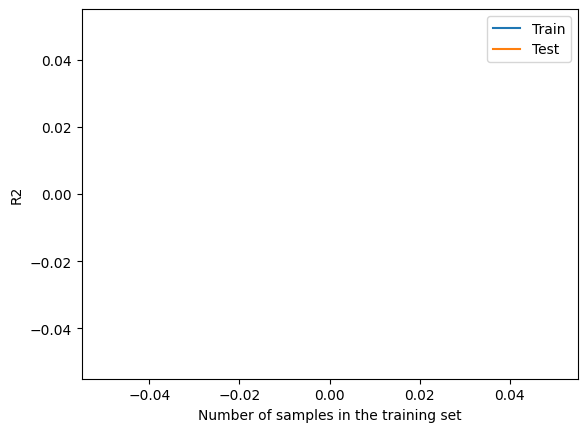

In [31]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="R2")
display.plot()
plt.show()

In [39]:
train_scores

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])